In [1]:
import numpy as np
from numpy import sqrt, log
import random
import matplotlib.pyplot as plt
import os
import math

In [2]:
directory='/Users/julnow/Desktop/szkoła/KMS/1/'
params = directory + 'params.txt'

lab 1

In [3]:
#read variables
variables = {}
with open(params) as f:
    for line in f:
        name, value = line.split(" = ")
        variables[name] = float(value)
n = int(variables['n'])
a = variables['a']
L = variables['L']
T0 =  variables['T']
R =  variables['R']
k = 8.31e-3 # Boltzman const
m = variables['m']# * 1.6605402e-27 # 1u
eps = variables['eps']
f = variables['f']
tau = variables['tau']
S_0 = int(variables['S_0'])
S_d = int(variables['S_d'])
S_out = int(variables['S_out'])
S_xyz = int(variables['S_xyz'])

# n = 3
# T0 = 10
#kryształ
#(3)
N = n**3 
# (4)
b0 = np.array([a, 0, 0])
b1 = np.array([a/2, a*sqrt(3)/2, 0])
b2 = np.array([a/2, a*sqrt(3)/6, a*sqrt(2/3)])
# (5)
ri = np.zeros([3, N])
for i0 in range(n):
    for i1 in range(n):
        for i2 in range(n):
            i = i0 + i1 * n + i2 * n**2
            r = (i0 - (n-1)/2)*b0 +  (i1- (n-1)/2)*b1 + (i2 - (n-1)/2)*b2
            ri[:,i] = r
# (6)
ei= np.zeros([3, N])
const = - k * T0 /2
for i in range(N):
    x = const*log(random.uniform(0, 1))
    y = const*log(random.uniform(0, 1))
    z = const*log(random.uniform(0, 1))
    ei[:,i] = np.array([x, y, z])
# (7)
pi= np.zeros([3, N])
for i in range(N):
    x = sqrt(2*m*ei[0, i])
    if (random.uniform(0, 1) < .5):
        x *= -1
    y = sqrt(2*m*ei[1, i])
    if (random.uniform(0, 1) < .5):
        y *= -1
    z = sqrt(2*m*ei[2, i])
    if (random.uniform(0, 1) < .5):
        z *= -1
    pi[:,i] = np.array([x, y, z])
# (8)
Px = sum(pi[0,:])
Py = sum(pi[1,:])
Pz = sum(pi[2,:])
for i in range(N):
    pi[0,i] -= Px/N
    pi[1,i] -= Py/N
    pi[2,i] -= Pz/N

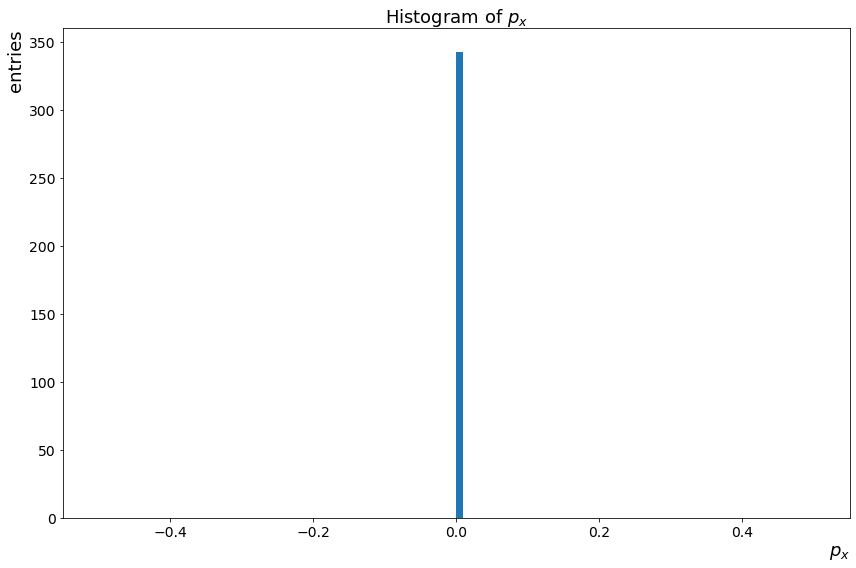

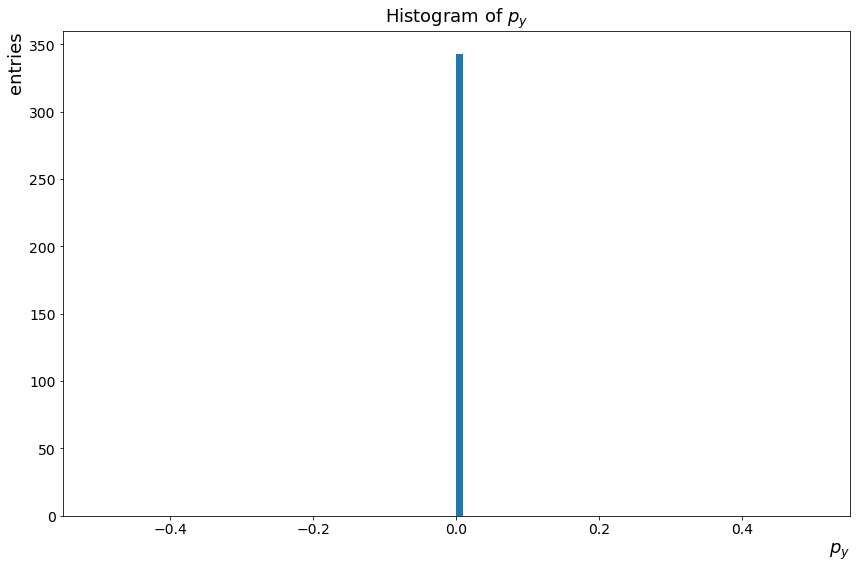

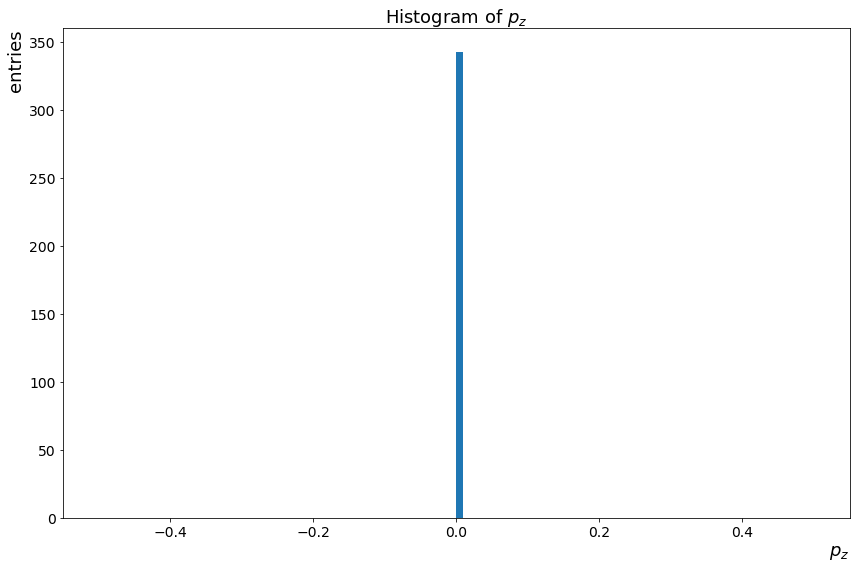

In [4]:
#plot histograms for momenta
coords = ['x', 'y', 'z']
count = 0
for coord in coords:
    fig, ax = plt.subplots(figsize=(12,8))
    name = r'$p_{' + coord + r'}$'
    plt.title(r'Histogram of ' + name , fontsize=18)
    plt.xlabel(name, fontsize=18, loc='right')
    plt.ylabel("entries", fontsize=18, loc='top')
    #plt.yscale('log')
    plt.hist(pi[count, :], bins=100)
    ax.tick_params(axis='both', which='major', labelsize=14)
    fig.tight_layout()
    count += 1

In [5]:
#create xyz file with positions
def create_file(name, mode):
    file_xyz = open(directory+name,mode)
    file_xyz.write(' '+ str(N) + '\n\n')
    for i in range(N):
        line = 'Ar' +  ' '
        x = ri[0, i]
        y = ri[1, i]
        z = ri[2, i]
        line += ' ' + str(x) + ' ' + str(y) + ' ' + str(z) + '\n'
        file_xyz.write(line)
    file_xyz.close()
filename = 'n' + str(n) + 'T' + str(T0)
create_file(filename + '.xyz', "w+")#new file mode

lab 2

In [6]:
#### (9)
Vp = np.zeros([N, N])
Vs = np.zeros([N])
Fs = np.zeros([3, N]) # (14)
Fp = np.zeros([3, N]) # (13)
Fi = np.zeros([3, N]) # (12)
P = 0
V = 0
def calculate(): #'algorytm 2'
    global ri, Vp, Vs, Fs, Fp, Fi, P, V, L
    P = 0
    V = 0
    Vs = np.zeros([N])
    Vp = np.zeros([N, N])
    Fs = np.zeros([3, N]) # (12)
    Fp = np.zeros([3, N]) # (12)
    Fi = np.zeros([3, N]) # (12)
    for i in range(N):
        r = np.linalg.norm(ri[:,i])
        if (r > L):
            Vs[i] = f*pow((r-L),2)/2 # (10)
            Fs[:, i] = f*(L-r) * (ri[:,i] / r) # (14)
        P += np.linalg.norm(Fs[:, i]) / 4/ math.pi / L**2 # (15)
        if (i > 0):
            for j in range(i):
                fi = 0
                ri_rj = ri[:,i] - ri[:,j] # x, y, z difference
                rr = np.linalg.norm(ri_rj) #sum of squares of x,y,z differences 
                Vp[i, j] = eps*( pow((R/rr), 12) - 2* pow((R/rr),6) ) # (9)
                fi = 12* eps*( pow((R/rr), 12) - pow((R/rr),6) ) * ri_rj / rr**2 # (13)
                Fp[:, i] += fi
                Fp[:, j] -= fi  
        
    V = np.sum(Vs) + np.sum(Vp) # (11)
    Fi = Fs + Fp
calculate()  
print ('V = ' + str(V))
print ('P = ' + str(P))
# (16)
H = 0 #hamiltionian
def hamiltionian():
    global H
    H = 0 
    for i in range(N):
        p = np.linalg.norm(pi[:, i])
        H += p**2 /2/m
    H += V
    # print('H = ' + str(H))
hamiltionian()
print ('H = ' + str(H))

V = 1430.5381773719387
P = 321.28786605782545
H = 1430.5381773719387


Lab 3

In [7]:
T = T0
E_kin = 0 # (19)
def simulation():
    global ri, pi, T, Fi, Ekin, Vp, Vs, Fs, Fp, Fi, P, V, L
    E_kin = 0
    for i in range(N):
        # (17 a)
        # print('Fi_tau = ' + str(Fi_tau))
        pi[:,i] +=  Fi[:, i]* tau/2  
        # (17 b)
        ri[:,i] += pi[:,i]*tau / m
    calculate()
    for i in range(N):
        # (17 c)
        pi[:,i] +=  Fi[:, i]* tau/2 
        # (19)
        p = np.linalg.norm(pi[:, i])
        E_kin += p**2 /2/m
    # print('P = ' + str(P))
    # print('H = ' + str(H))
    T = 2 / (3*N*k)  * E_kin # (19)
    hamiltionian()
    # print('T = ' + str(T))

In [ ]:
T_bar, P_bar, H_bar = 0, 0, 0 # (20)
H_t, T_t, p_t, time = [], [], [], []
if not os.path.exists(directory+'polozenia'):
    os.makedirs(directory+'polozenia')
def bar(var, name):
    var = var /S_d
    print(r'$\overline{' + name + r'}$ = ' + str(var))
'''simulation'''
t = 0.
for s in range (S_0 + S_d):
    simulation()
    t += tau
    if (s > S_0):
        if (s % S_out == 0):
            # print('t = ' + str(t))
            # print('H = ' + str(H))
            H_t.append(H)
            # print('V = ' + str(V))
            # print('T = ' + str(T))
            T_t.append(T)
            # print('P = ' + str(P))
            p_t.append(P)
            time.append(t)
        if (s % S_xyz == 0):
            # create_file('polozenia/polozenie'+str(t)+'.xyz')
            create_file(filename + '.xyz', "a") #append mode
        T_bar += T
        P_bar += P
        H_bar += H
bar(T_bar, 'T')
bar(P_bar, 'P')
bar(H_bar, 'H')

In [ ]:
if not os.path.exists(directory+'wykresy'):
    os.makedirs(directory+'/wykresy')
def histogram(var, time, name, info, ticks = 0):
    fig, ax = plt.subplots(figsize=(12,8))
    plt.title(r'Histogram of ' + name + ', '+ info, fontsize=18)
    plt.xlabel('t', fontsize=18, loc='right')
    plt.ylabel(name, fontsize=18, loc='top')
    if (ticks == 1):
        plt.yticks(np.arange(min(var), max(var)+1, step=.01))
        ax.get_yaxis().get_major_formatter().set_scientific(False)
        ax.get_yaxis().get_major_formatter().set_useOffset(False)
    #plt.yscale('log')
    plt.plot(time, var)
    ax.tick_params(axis='both', which='major', labelsize=14)
    # plt.yticks(np.arange(min(var), max(var), step=0.01))
    fig.tight_layout()
    plt.savefig(directory+'/wykresy/' + name + '_' + info + '.png')
    plt.show()   
info = '$n$ = ' + str(n) + ', T$_0$ = ' + str(T0)              
histogram(H_t, time, 'H(t)', info, 1)
histogram(T_t, time, 'T(t)', info)
histogram(p_t, time, 'p(t)', info)